In [2]:
print("hello")

hello


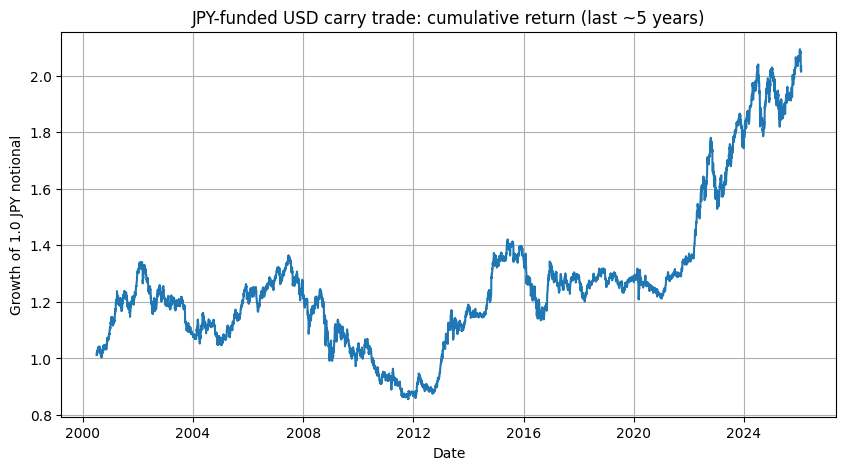

Calendar-year returns (JPY terms):
observation_date
2000     11.01%
2001     18.18%
2002     -8.14%
2003    -10.07%
2004     -2.93%
2005      15.7%
2006      5.65%
2007     -4.67%
2008    -16.08%
2009      1.61%
2010    -11.82%
2011     -5.98%
2012     13.65%
2013      20.4%
2014     14.67%
2015      -0.7%
2016     -1.07%
2017     -3.98%
2018     -1.36%
2019      0.81%
2020     -4.57%
2021     11.79%
2022     14.85%
2023     12.32%
2024     15.07%
2025      2.05%
2026     -1.36%
dtype: object


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# --- Parameters ---
end = date.today()
start = end - timedelta(days=365*40 + 10)  # ~5y buffer
start_s = start.isoformat()
end_s = end.isoformat()

def fred_csv(series_id, start_date, end_date):
    url = (
        "https://fred.stlouisfed.org/graph/fredgraph.csv"
        f"?id={series_id}&cosd={start_date}&coed={end_date}"
    )
    df = pd.read_csv(url)

    # FRED uses 'observation_date' in this endpoint
    df["observation_date"] = pd.to_datetime(df["observation_date"])
    df = df.set_index("observation_date")

    # Clean missing values and coerce to numeric
    df = df.replace(".", np.nan)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

# --- Fetch data ---
fx = fred_csv("DEXJPUS", start_s, end_s).rename(columns={"DEXJPUS": "USDJPY"})  # JPY per USD
us = fred_csv("EFFR", start_s, end_s).rename(columns={"EFFR": "r_us"})         # % p.a., daily
jp = fred_csv("IRSTCI01JPM156N", start_s, end_s).rename(columns={"IRSTCI01JPM156N": "r_jp"})  # % p.a., monthly

# --- Align frequencies ---
# Daily calendar from FX (business-day-ish); forward-fill rates.
data = fx.join(us, how="left").join(jp, how="left")
data["r_us"] = data["r_us"].ffill()
data["r_jp"] = data["r_jp"].ffill()

# Drop days where FX is missing (holidays)
data = data.dropna(subset=["USDJPY", "r_us", "r_jp"]).copy()

# --- Carry trade daily return in JPY terms ---
# Use ACT/360 daycount (common for money markets); you can switch to 365 if desired.
dt = 1/360
r_us = data["r_us"] / 100.0
r_jp = data["r_jp"] / 100.0

# FX gross return: S_{t+1}/S_t
fx_gross = data["USDJPY"].shift(-1) / data["USDJPY"]

# Interest gross returns over one day
us_gross = 1 + r_us * dt
jp_gross = 1 + r_jp * dt

gross = fx_gross * (us_gross / jp_gross)

# Last row has no t+1 FX
gross = gross.iloc[:-1]
ret = gross - 1.0

# Cumulative index (start at 1.0)
cum = (1 + ret).cumprod()
cum.name = "JPY-funded long USD carry (cumulative)"

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(cum.index, cum.values)
plt.title("JPY-funded USD carry trade: cumulative return (last ~5 years)")
plt.xlabel("Date")
plt.ylabel("Growth of 1.0 JPY notional")
plt.grid(True)
plt.show()

# Optional: show where the action is (calendar-year returns)
yr = (1 + ret).groupby(ret.index.year).prod() - 1
print("Calendar-year returns (JPY terms):")
print((yr * 100).round(2).astype(str) + "%")


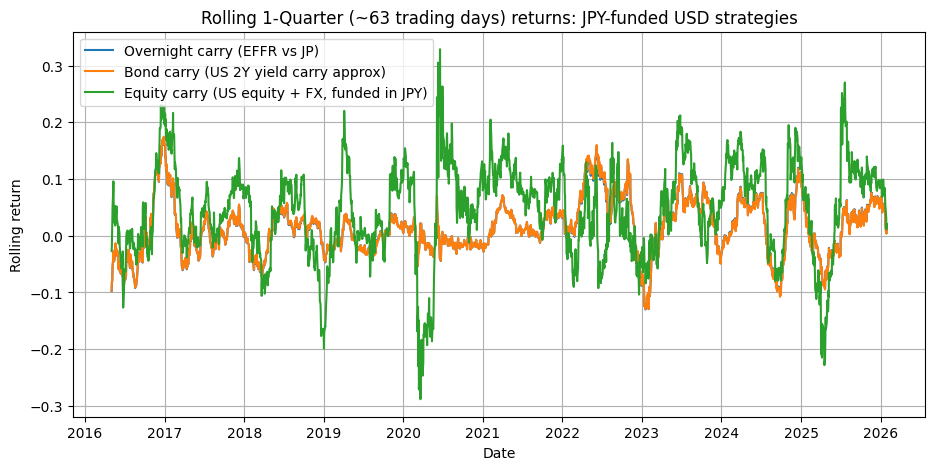

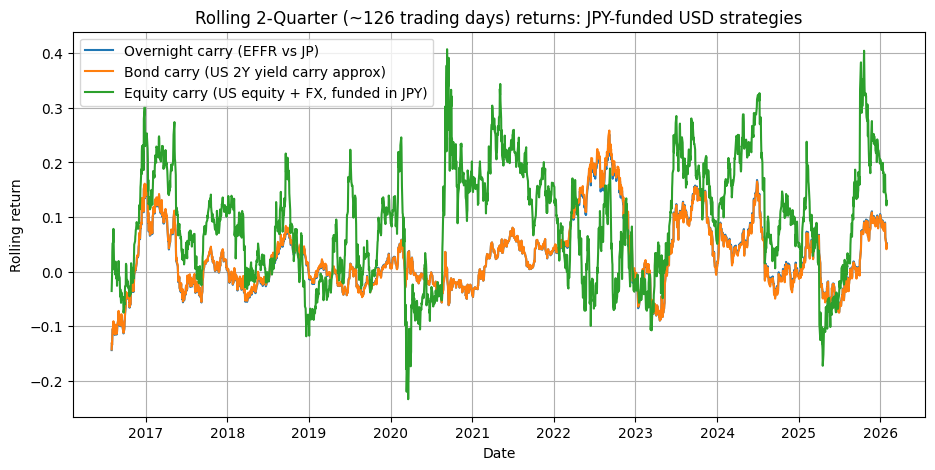

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------- Helpers ----------
def rolling_horizon_return(daily_simple_returns, window):
    """rolling compounded return over 'window' trading days"""
    return (1 + daily_simple_returns).rolling(window).apply(np.prod, raw=True) - 1

# ---------- Date range ----------
end = date.today()
start = end - timedelta(days=365*25 + 10)
start_s, end_s = start.isoformat(), end.isoformat()

# ---------- Pull core series ----------
fx = fred_csv("DEXJPUS", start_s, end_s)
fx.columns = ["USDJPY"]  # JPY per USD

jp = fred_csv("IRSTCI01JPM156N", start_s, end_s)
jp.columns = ["r_jp"]    # % p.a. (monthly, forward fill later)

# US overnight (for baseline comparison if you want it)
us_overnight = fred_csv("EFFR", start_s, end_s)
us_overnight.columns = ["r_us_overnight"]  # % p.a.

# ---------- Variant B input (bond yield carry approximation) ----------
# Pick ONE: 2Y or 5Y. FRED series are typically DGS2, DGS5.
us_yield = fred_csv("DGS2", start_s, end_s)   # 2-year constant maturity Treasury yield (%)
us_yield.columns = ["y_us"]                   # % p.a.

# ---------- Variant C input (equity) ----------
# If you have an equity series you can pull, put it here.
# Placeholder example: use Wilshire 5000 price index (FRED has WILL5000PR) if available.
# If this series errors, swap to another equity proxy you have access to.
spx = fred_csv("SP500", start_s, end_s)
spx.columns = ["eq"]

# ---------- Align & clean ----------
data = fx.join([jp, us_overnight, us_yield, spx], how="left")
data = data.sort_index()

# forward-fill rates and equity (equity shouldn't need ffill unless missing holidays)
data["r_jp"] = data["r_jp"].ffill()
data["r_us_overnight"] = data["r_us_overnight"].ffill()
data["y_us"] = data["y_us"].ffill()
data["eq"] = data["eq"].ffill()

# keep only rows where we have everything
data = data.dropna(subset=["USDJPY", "r_jp", "r_us_overnight", "y_us", "eq"]).copy()

# ---------- Common pieces ----------
dt = 1/360
r_jp = (data["r_jp"] / 100.0)
usd_jpy = data["USDJPY"]

# FX simple return: (S_{t+1}/S_t) - 1
fx_ret = usd_jpy.shift(-1) / usd_jpy - 1
fx_ret = fx_ret.iloc[:-1]

# ---------- Baseline (overnight cash carry) ----------
r_us = (data["r_us_overnight"] / 100.0)
carry_cash = ((1 + r_us*dt) / (1 + r_jp*dt)) - 1
carry_cash = carry_cash.iloc[:-1]

ret_baseline = (1 + fx_ret) * (1 + carry_cash) - 1
ret_baseline.name = "Overnight carry (EFFR vs JP)"

# ---------- Variant B: Bond carry (yield-carry approximation) ----------
# daily USD "bond carry" ≈ y_us/360
y_us = (data["y_us"] / 100.0)
usd_bond_carry = y_us * dt
usd_bond_carry = usd_bond_carry.iloc[:-1]

# Net carry = earn US bond carry, pay JP funding
carry_bond = ((1 + usd_bond_carry) / (1 + r_jp.iloc[:-1]*dt)) - 1
ret_bond = (1 + fx_ret) * (1 + carry_bond) - 1
ret_bond.name = "Bond carry (US 2Y yield carry approx)"

# ---------- Variant C: Equity carry ----------
# equity daily return (price return proxy)
eq = data["eq"]
eq_ret = eq.shift(-1) / eq - 1
eq_ret = eq_ret.iloc[:-1]

# Strategy: borrow JPY, hold USD equities unhedged
fund_cost = r_jp.iloc[:-1] * dt
ret_equity = (1 + fx_ret) * (1 + eq_ret) / (1 + fund_cost) - 1
ret_equity.name = "Equity carry (US equity + FX, funded in JPY)"

# ---------- Rolling horizons (Number 4) ----------
W1Q = 63
W2Q = 126

roll_1q = pd.concat([
    rolling_horizon_return(ret_baseline, W1Q),
    rolling_horizon_return(ret_bond, W1Q),
    rolling_horizon_return(ret_equity, W1Q),
], axis=1)

roll_2q = pd.concat([
    rolling_horizon_return(ret_baseline, W2Q),
    rolling_horizon_return(ret_bond, W2Q),
    rolling_horizon_return(ret_equity, W2Q),
], axis=1)

# ---------- Plot: Rolling 1Q ----------
plt.figure(figsize=(11, 5))
plt.plot(roll_1q.index, roll_1q.iloc[:,0], label=roll_1q.columns[0])
plt.plot(roll_1q.index, roll_1q.iloc[:,1], label=roll_1q.columns[1])
plt.plot(roll_1q.index, roll_1q.iloc[:,2], label=roll_1q.columns[2])
plt.title("Rolling 1-Quarter (~63 trading days) returns: JPY-funded USD strategies")
plt.xlabel("Date")
plt.ylabel("Rolling return")
plt.grid(True)
plt.legend()
plt.show()

# ---------- Plot: Rolling 2Q ----------
plt.figure(figsize=(11, 5))
plt.plot(roll_2q.index, roll_2q.iloc[:,0], label=roll_2q.columns[0])
plt.plot(roll_2q.index, roll_2q.iloc[:,1], label=roll_2q.columns[1])
plt.plot(roll_2q.index, roll_2q.iloc[:,2], label=roll_2q.columns[2])
plt.title("Rolling 2-Quarter (~126 trading days) returns: JPY-funded USD strategies")
plt.xlabel("Date")
plt.ylabel("Rolling return")
plt.grid(True)
plt.legend()
plt.show()
